# Portfolio Methodolgy

1. DGI/Growth Names - Rebalance every 6 months picking around 2 - 3 names from CA and US universe
    - Sell Covered Calls on names and re-enter if called away.
    - **GTC Stop Limit of 5% on each name**
2. VAA/PAA - Rebalance every month on trading day 1
3. LEAPS - Rebalance every 3 months picking around 3 - 8 names from US universe (high growth potential names)
    - Current Holdings: LOPE STOR PNW SBUX
    - LOPE Earnings: Nov 8
    - PNW Earnings: Nov 8
    - SBUX Earnings: Jan 23
        - **Exit Criteria: When the call option drops below 60 delta**
4. Short Vol - Short SPX Spreads at the beginning of the month and hold until second or last week to maturity
    - Potentially long UVXY/VXX puts at beginning of the month with bracket orders
    - **Short ATM SPX Put spreads around 25 points wide**
        - **Long bi-weekly unit puts, around -7% or so of SPX spot (or something with a cost of 15% of the credit)**
        - **The SPX put spread will have a capped max loss of 2,500 per contract, while in low volatility, the bi-weekly units are severely underpriced and will explode 10X to 20X in value if the long strike in the spread gets tested. Vega and Gamma play a huge factor in the repricing of these units.**
        - Initiate the units every 2 weeks letting them run to expiry
    - ***When in lower vol environment or when skew is less pronounced in high vol environments, it is possible to select spreads and units with the same expiry and still receive a deccent net credit. Otherwise, when IV is very high, check if same expiries are possible, otherwise choose units that expire in half the time.***
5. Barbell Hedging
    - Long SPX puts or VIX calls during high crisis potential moments
        - Initiate bracket orders with SPX Puts: +/- 30% of Cost Basis
    - Check VIX Futures volume trends and see impact of Feb 5, 2018
    - Only trade 4 naked SPX puts in Reg accounts
        - Sell half into profits/losses 
    - Only trade 6 3:1 Put back ratios in Reg Account: Leg into these positions because of how illiquid the market is
    - Take losses immediately (10% - 30% of Cost Basis)
    - NEVER EVER try to put on a position of the market is illiquid: YOU WILL get filled at horrible prices
    - **Put on 1-5 Delta strangles on the open of the day and close position at the end of the day around 2 pm to 3 pm**
6. Treasuries - Re-establish monthly bills beginning of month or at maturity
7. Earnings
    - Filter stocks with market cap > 500M and with post-earnings returns greater than 2% in magnitude for at least 3 quarters
    - Then filter stocks whose options have bid-ask spreads less than 1 dollar ATM
    - Aggregate all insider share buys and sells and calculate the ratio Buy/Sells
        - Candidates for Puts have Buy/Sell < 0.5
        - Candidates for Calls have Buy/Sell > 2
8. **0 DTE Spreads trading**
    - Start day with 1 to 3 contracts max on either call or put spreads with emphasis on keeping short contract below 10 delta at the beginning of the day.
    - Trade small (10 contracts max) in the morning from 10 am to 12 pm (or earlier)
    - Start reducing size at 11 am and taking profits or losses by noon
    - Monitor trends and add more contracts after 1 or 2 pm in the afternoon
    - If trend is reversing and your contracts are 10 points from the money, reposition or close out depending on MA and Squeeze Bars
    - **When low IV, short spread legs should be very close to the money while in high IV, short spread legs should be farther from the money, around 20 to 10 deltas.**

##### Strategy Weights
|Strategy|Weight|Last Rebal|Next Check|Next Full Rebal|
|-|-|-|-|-|
|VAA/PAA|25%|11/01/2018|12/01/2018|12/01/2018|
|LEAPs|5%|11/01/2018|12/01/2018|01/01/2019|
|Short Vol|2%|NA|NA|NA|
|Barbell Hedging|1.5%|11/06/2018|11/09/2018|11/19/2018|
|Treasuries|60%|11/01/2018|11/29/2018|12/01/2018|

## Key Modules to Run

- fundamental_data_collect.py to run monthly to collected latest financial statements and key stats from yahoo
- finstatement_cleaning.py to run right after fundamental_data_collect.py to create cleaned data for earnings plays



In [1]:
# Importing necessary models
import warnings
warnings.filterwarnings('ignore')

import smtplib
import pandas as pd
import numpy as np
import datetime as dt
import pandas.stats.moments as st
import time
%matplotlib inline
from bs4 import BeautifulSoup as bs
import requests
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sqlalchemy import *
from sqlalchemy import create_engine
import calendar
import sqlite3 as sql
pd.options.display.float_format = '{:,.4f}'.format

init_notebook_mode(connected=True)

import os
main_dir = os.getcwd()

dbs_dir = 'C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Data\\DBs'

os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\DataCollection')

from alphavantage import *
from yahoo_query import *
from option_slam_earnings import *
from reuters_query import reuters_query, reuters_insiders
from alphaquery import alphaquery

os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\Options')
from optionsFunctions import *

os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\Earnings')
from yahoo_earnings import *
from lookup_earnings import lookup_earnings

os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\Processing')
from hv_calc import *

os.chdir(main_dir)

dbs_dir = 'C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Data\\DBs'

os.chdir(dbs_dir)

earn_engine = create_engine('sqlite:///earningsHistory.db', echo=False)
yahoo_engine = create_engine('sqlite:///yahoo.db', echo = False)
reuters_engine = create_engine('sqlite:///reuters.db', echo=False)

# Allocate Smartly Checking

In [8]:
# Short Call Assignment Price - 287.5

portfolio_value =  200000

as_lst = ['DBC',
        'HYG',
        'IEF',
        'IWM',
        'LQD',
        'QQQ',
        'SPY',
        'VNQ']
as_wgt = [0.0,
        0.0,
        1.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0]

as_df = pd.DataFrame({'Allocation': as_wgt}, index = as_lst)
curr_spot = curr_batch_quotes(as_lst)
as_df = pd.concat([as_df,curr_spot[['price']]], axis = 1)

as_df['Market Value'] = portfolio_value*as_df.Allocation
as_df['Holdings'] = np.round(as_df['Market Value']/as_df.price,0)

as_df

,Allocation,price,Market Value,Holdings
symbol,,,,
DBC,0.0000,15.5500,0.0000,0.0000
HYG,0.0000,84.4100,0.0000,0.0000
IEF,1.0000,103.8250,"200,000.0000","1,926.0000"
IWM,0.0000,147.3200,0.0000,0.0000
LQD,0.0000,115.0500,0.0000,0.0000
QQQ,0.0000,165.2100,0.0000,0.0000
SPY,0.0000,265.8100,0.0000,0.0000
VNQ,0.0000,80.4550,0.0000,0.0000


## Checking market correlations - https://fang-trading-dashboard.herokuapp.com

In [9]:
# rolling_window = 60
# plot_window = 10000

# corr_df, sector_df = check_mkt_corr(rolling_window, plot_window)
# print(corr_df.tail())

In [10]:
# ((sector_df.dropna() + 1).cumprod()-1).tail()

In [11]:
# corr_df.iloc[:,:-2].plot(figsize = (20,10))

## Checking SP500 Components

In [12]:
def nsdq_earnings_date(ticker):
    try:
        nasdaq_earnings_link = 'https://www.nasdaq.com/earnings/report/{}'.format(ticker.lower())
        nasdaq_earnings_soup = bs(requests.get(nasdaq_earnings_link).text, 'lxml')
        next_earnings = nasdaq_earnings_soup.select_one('h2').text.strip().split(': ')[-1]
        next_earnings = dt.datetime.strptime(next_earnings, '%b %d, %Y')
    except:
        next_earnings = np.nan
    return next_earnings

start_time = time.time()

sp500_const_url = 'https://www.slickcharts.com/sp500'
sp500_const_html = requests.get(sp500_const_url).text
soup_sp500_const = bs(sp500_const_html, 'lxml')
sp500_table_text = soup_sp500_const.find_all('table')[0]
sp500_const_dict = {}
sp500_const_dict['NextEarnings'] = []
headers = []

for i,row in enumerate(sp500_table_text.find_all('tr')):
    
    if i == 0:
        cols = row.find_all('th')
    
        for j, col in enumerate(cols):
            if j == 0:
                continue
            else:
                headers.append(col.text)
                sp500_const_dict[col.text] = []
    else:
        cols = row.find_all('td')
        
        for j, col in enumerate(cols):
            if j == 0:
                continue
            else:
                
                current_value = col.text.strip().replace(',','')
                if j == 2:
                    earnings = nsdq_earnings_date(current_value)
                    sp500_const_dict['NextEarnings'].append(earnings)
                if j == 3 or j == 4:
                    current_value = float(current_value)
                elif j == 5:
                    current_value = current_value.split(' ')[-1].replace('(','').replace(')','').replace('%','')
                    
                sp500_const_dict[headers[j - 1]].append(current_value)
                
sp500_const = pd.DataFrame(sp500_const_dict)
sp500_const['CumulativeWeight'] = sp500_const.Weight.cumsum()

yahoo_profiles = pd.read_sql_query('SELECT * FROM {0}'.format('profiles'),
                                   con = yahoo_engine, index_col = 'Underlying')

sp500_const = sp500_const.set_index('Symbol').join(yahoo_profiles[['industry','sector']], how = 'left').drop_duplicates()

print("--- %s seconds ---" % (time.time() - start_time))

--- 227.15217518806458 seconds ---


In [13]:
top_n = 50

sp500_const.sort_values('CumulativeWeight').head(top_n)[['sector',
                                                         'Weight']].groupby(['sector']).agg({'Weight': 'sum'}).sort_values('Weight')

,Weight
sector,
Basic Materials,0.5826
Energy,2.3399
Industrials,2.3600
Communication Services,2.8086
Consumer Defensive,3.7127
Consumer Cyclical,6.4623
Financial Services,6.7785
Healthcare,7.3526
Technology,15.9158


In [14]:
print(os.getcwd())
sp500_const.sort_values('NextEarnings').to_csv('spx_earnings.csv')

C:\Users\Fang\Desktop\Python Trading\Trading\Data\DBs


In [15]:
sp500_const

,Change,Company,NextEarnings,Price,Weight,CumulativeWeight,industry,sector
A,0.00,Agilent Technologies Inc.,2019-02-20,73.6500,0.1027,83.6471,Diagnostics & Research,Healthcare
AAL,0.60,American Airlines Group Inc.,NaT,35.1900,0.0618,92.1147,Airlines,Industrials
AAP,-0.97,Advance Auto Parts Inc.,2019-02-20,151.7400,0.0516,95.2068,Specialty Retail,Consumer Cyclical
AAPL,0.04,Apple Inc.,2019-01-29,157.8200,3.1040,6.8023,Consumer Electronics,Technology
ABBV,0.06,AbbVie Inc.,2019-01-25,80.5900,0.5829,41.7426,Drug Manufacturers - Major,Healthcare
ABC,-0.08,AmerisourceBergen Corporation,2019-01-31,79.6000,0.0564,93.7605,Medical Distribution,Healthcare
ABMD,1.61,ABIOMED Inc.,2019-01-31,355.0000,0.0701,90.4159,NaN,NaN
ABT,0.00,Abbott Laboratories,NaT,71.1500,0.5609,44.0277,Medical Devices,Healthcare
ACN,0.00,Accenture Plc Class A,NaT,151.8500,0.4312,51.8191,Information Technology Services,Technology
ADBE,0.00,Adobe Inc.,2019-03-21,244.9500,0.5323,45.1022,Software - Application,Technology


## Earnings

In [16]:
# Fin Statement 

def balancesheet_sum(balance_sheet, period):
    balance_sheet = balance_sheet.fillna(np.nan)
    
    bs_summary = balance_sheet[[period, 'cash', 'totalCurrentAssets', 'totalAssets', 'totalLiab','totalStockholderEquity']]

    bs_ratios = balance_sheet[[period]]

    bs_ratios['current_ratio'] = pd.to_numeric(balance_sheet['totalCurrentAssets'])/pd.to_numeric(balance_sheet['totalCurrentLiabilities'])
    bs_ratios['total_debt_equity_ratio'] = pd.to_numeric(balance_sheet['totalCurrentLiabilities'])/pd.to_numeric(balance_sheet['totalStockholderEquity'])

    bs_summary[bs_summary.columns.tolist()[1:]] = bs_summary[bs_summary.columns.tolist()[1:]].apply(lambda x: pd.to_numeric(x)).pct_change()
    bs_ratios[['current_ratio_changes','total_debt_equity_changes']] = bs_ratios[['current_ratio','total_debt_equity_ratio']].pct_change()
    bs_summary = bs_summary.merge(bs_ratios, on = period)
    bs_summary['Underlying'] = ticker
    bs_summary = bs_summary.set_index('Underlying')
    return bs_summary

def cashflows_sum(cashflows, period):
    cashflows['fcf'] = pd.to_numeric(cashflows['totalCashFromOperatingActivities']) - pd.to_numeric(cashflows['totalCashflowsFromInvestingActivities'])
    cashflow_sum = cashflows[[period, 'fcf', 'capitalExpenditures', 'dividendsPaid', 'investments']].fillna(0)
    cashflow_sum[cashflow_sum.columns.tolist()[1:]] = cashflow_sum[cashflow_sum.columns.tolist()[1:]].apply(lambda x: pd.to_numeric(x)).pct_change()
    cashflow_sum['changeToOperatingActivities'] = pd.to_numeric(cashflows['changeToOperatingActivities'])/pd.to_numeric(cashflows['totalCashFromOperatingActivities'])
    cashflow_sum['Underlying'] = ticker
    cashflow_sum = cashflow_sum.set_index('Underlying')
    
    return cashflow_sum


def income_summary(incomestatement, period):

    income_sum = incomestatement[[period, 'grossProfit','operatingIncome', 'netIncome', 'totalRevenue', 'totalOperatingExpenses', 'researchDevelopment']]
    income_sum = income_sum.fillna(np.nan)
    income_ratios = income_sum[[period]]
    income_ratios['gross_margin'] = pd.to_numeric(income_sum['grossProfit'])/pd.to_numeric(income_sum['totalRevenue'])
    income_ratios['operating_margin'] = pd.to_numeric(income_sum['operatingIncome'])/pd.to_numeric(income_sum['totalRevenue'])
    income_ratios['net_profit_margin'] = pd.to_numeric(income_sum['netIncome'])/pd.to_numeric(income_sum['totalRevenue'])
    income_sum[[x + '_changes' for x in income_ratios.columns.tolist()[1:]]] = income_ratios[income_ratios.columns.tolist()[1:]]
    income_sum[income_sum.columns.tolist()[1:]] = income_sum[income_sum.columns.tolist()[1:]].apply(lambda x: pd.to_numeric(x)).pct_change()
    income_sum = income_sum.merge(income_ratios, on = period)
    income_sum['Underlying'] = ticker
    income_sum = income_sum.set_index('Underlying')
    
    return income_sum

def score_statement(statement):

    short_score = 0
    long_score = 0

    require_positives = ['cash', 'current_ratio_changes', 'fcf', 'capitalExpenditures', 'investments',
                         'grossProfit', 'operatingIncome', 'netIncome', 'totalRevenue' ,'researchDevelopment',
                         'gross_margin_changes','net_profit_margin_changes','operating_margin_changes',
                         'gross_margin','operating_margin','net_profit_margin','earnings','revenue']
    require_negatives = ['totalLiab','total_debt_equity_ratio','total_debt_equity_changes','totalOperatingExpenses']

    for idx, row in statement.T.iterrows():
        num_of_periods = len(statement)
        if idx == 'year' or idx == 'quarter':
            continue
        curr_line_check = sum(row.values > 0)

        if idx in require_positives and curr_line_check == num_of_periods:
            long_score += 1

        if idx in require_positives and curr_line_check == 0:
            short_score += 1

        if idx in require_negatives and curr_line_check == 0:
            long_score += 1

        if idx in require_negatives and curr_line_check == num_of_periods:
            short_score += 1
            
    return [long_score, short_score]

def yahoo_assess(yahoo_info, ticker):
    annual_statements = []
    quarterly_statements = []

    for k, v in yahoo_info.items():
        current_table = v[v.index == ticker].drop_duplicates().replace('na',np.nan)
        if len(current_table) > 0:
            if 'BalanceSheet' in k:
                period = list(filter(lambda x: x in ['year','quarter'], current_table.columns.tolist()))[0]
                balancesheet = balancesheet_sum(current_table, period)
                if period == 'year':
                    annual_statements.append(balancesheet)
                else:
                    quarterly_statements.append(balancesheet)
                #yahoo_info[k] = balancesheet
            elif 'CashFlow' in k:
                period = list(filter(lambda x: x in ['year','quarter'], current_table.columns.tolist()))[0]
                cashflows = cashflows_sum(current_table, period)
                if period == 'year':
                    annual_statements.append(cashflows)
                else:
                    quarterly_statements.append(cashflows)
                #yahoo_info[k] = cashflows
            elif 'annualEarnings' in k:
                period = list(filter(lambda x: x in ['year','quarter'], current_table.columns.tolist()))[0]
                earnings = current_table
                earnings[earnings.columns.tolist()[1:]] = earnings[earnings.columns.tolist()[1:]].apply(lambda x: pd.to_numeric(x)).pct_change()
                #yahoo_info[k] = earnings
            elif 'IncomeStatement' in k:
                period = list(filter(lambda x: x in ['year','quarter'], current_table.columns.tolist()))[0]
                incomestatement = income_summary(current_table, period)
                if period == 'year':
                    annual_statements.append(incomestatement)
                else:
                    quarterly_statements.append(incomestatement)
                #yahoo_info[k] = incomestatement
            elif k == 'finData':
                finData = current_table[['earningsGrowth','revenueGrowth','freeCashflow','totalCash']].drop_duplicates()
            else:
                profile = current_table[['industry','sector']].drop_duplicates()

    annual_statements = pd.concat(annual_statements, axis = 1)
    annual_statements = annual_statements.T[~annual_statements.T.index.duplicated(keep='first')].T
    annual_statements['year'] = pd.to_datetime(annual_statements['year'])
    #annual_statements[['earnings','revenue']] = earnings[['earnings','revenue']]
    annual_statements['earnings'] = earnings['earnings'].values
    annual_statements['revenue'] = earnings['revenue'].values
    annual_statements = annual_statements.tail(len(annual_statements) - 1)

    quarterly_statements = pd.concat(quarterly_statements, axis = 1)
    quarterly_statements = quarterly_statements.T[~quarterly_statements.T.index.duplicated(keep='first')].T
    quarterly_statements['quarter'] = pd.to_datetime(quarterly_statements['quarter'])
    quarterly_statements = quarterly_statements.tail(len(quarterly_statements) - 1)

    ticker_profile = profile.join(finData)

    annual_scores = score_statement(annual_statements)
    quarterly_scores = score_statement(quarterly_statements)

    ticker_profile.loc[ticker, 'annualLongScore'] = annual_scores[0]
    ticker_profile.loc[ticker, 'annualShortScore'] = annual_scores[1]
    ticker_profile.loc[ticker, 'quarterlyLongScore'] = quarterly_scores[0]
    ticker_profile.loc[ticker, 'quarterlyshortScore'] = quarterly_scores[1]

    return ticker_profile, annual_statements, quarterly_statements

def convertReportDate(reportdate):
    curr_date = dt.datetime.strptime(reportdate.split(' ')[-1], '%b-%y')
    date_range = calendar.monthrange(curr_date.year,curr_date.month)
    date = dt.datetime(curr_date.year,curr_date.month,date_range[1])
    return date

In [17]:
def reuters_assess(ticker, reuters_info):
    reuters_fundamentals = []

    reuters_long_score = 0
    reuters_short_score = 0

    for k, v in reuters_info.items():
        if k in ['earningsAnalysis','efficiency','performanceSummary','salesAnalysis']:
            continue
        current_table = v[v.index == ticker].drop_duplicates()
        if len(current_table) > 0:
            if 'PullDate' in current_table.columns:
                current_table = current_table.sort_values('PullDate', ascending = False)
                current_table = current_table[current_table['PullDate'] == current_table.PullDate.values[0]]
                del current_table['PullDate']

            if k == 'overviews':
                reuter_overview = current_table[['LastPrice', 'High52Week','Low52Week']]
            if k in ['dividends', 'financialStrength','growthRates','managementAbilities','profitability']:
                reuters_fundamentals.append(current_table)
                fund_table = current_table.set_index('Field')
                for field in fund_table.index:
                    if field not in ['LT Debt to Equity (MRQ)','Total Debt to Equity (MRQ)','Effective Tax Rate (TTM)','Effective Tax Rate - 5 Yr. Avg.']:
                        if fund_table.loc[field,'Company'] > fund_table.loc[field,'industry'] and fund_table.loc[field,'Company'] > fund_table.loc[field,'sector']:
                            reuters_long_score += 1
                        if fund_table.loc[field,'Company'] < fund_table.loc[field,'industry'] and fund_table.loc[field,'Company'] < fund_table.loc[field,'sector']:
                            reuters_short_score += 1
                    elif field in ['LT Debt to Equity (MRQ)','Total Debt to Equity (MRQ)']:
                        if fund_table.loc[field,'Company'] > fund_table.loc[field,'industry'] and fund_table.loc[field,'Company'] > fund_table.loc[field,'sector']:
                            reuters_short_score += 1
                        if fund_table.loc[field,'Company'] < fund_table.loc[field,'industry'] and fund_table.loc[field,'Company'] < fund_table.loc[field,'sector']:
                            reuters_long_score += 1

                if k == 'dividends':
                    try:
                        if fund_table.loc['Dividend Yield', 'Company'] > fund_table.loc['Dividend Yield - 5 Year Avg', 'Company']:
                            reuters_long_score += 1
                        if fund_table.loc['Dividend Yield', 'Company'] < fund_table.loc['Dividend Yield - 5 Year Avg', 'Company']:
                            reuters_short_score += 1
                    except:
                        None

                if k == 'growthRates':
                    try:
                        if fund_table.loc['Sales (TTM) vs TTM 1 Yr. Ago', 'Company'] > fund_table.loc['Sales - 5 Yr. Growth Rate', 'Company']:
                            reuters_long_score += 1
                        if fund_table.loc['Sales (TTM) vs TTM 1 Yr. Ago', 'Company'] < fund_table.loc['Sales - 5 Yr. Growth Rate', 'Company']:
                            reuters_short_score += 1
                    except:
                        None
                    try:
                        if fund_table.loc['EPS (TTM) vs TTM 1 Yr. Ago', 'Company'] > fund_table.loc['EPS - 5 Yr. Growth Rate', 'Company']:
                            reuters_long_score += 1
                        if fund_table.loc['EPS (TTM) vs TTM 1 Yr. Ago', 'Company'] < fund_table.loc['EPS - 5 Yr. Growth Rate', 'Company']:
                            reuters_short_score += 1
                    except:
                        None

                if k == 'managementAbilities':
                    try:
                        if fund_table.loc['Return on Assets (TTM)', 'Company'] > fund_table.loc['Return on Assets - 5 Yr. Avg.', 'Company']:
                            reuters_long_score += 1
                        if fund_table.loc['Return on Assets (TTM)', 'Company'] < fund_table.loc['Return on Assets - 5 Yr. Avg.', 'Company']:
                            reuters_short_score += 1
                    except:
                        None
                        
                    try:
                        if fund_table.loc['Return on Investment (TTM)', 'Company'] > fund_table.loc['Return on Investment - 5 Yr. Avg.', 'Company']:
                            reuters_long_score += 1
                        if fund_table.loc['Return on Investment (TTM)', 'Company'] < fund_table.loc['Return on Investment - 5 Yr. Avg.', 'Company']:
                            reuters_short_score += 1
                    except:
                        None
                    
                    try:
                        if fund_table.loc['Return on Equity (TTM)','Company'] > fund_table.loc['Return on Equity - 5 Yr. Avg.', 'Company']:
                            reuters_long_score += 1
                        if fund_table.loc['Return on Equity (TTM)','Company'] < fund_table.loc['Return on Equity - 5 Yr. Avg.', 'Company']:
                            reuters_short_score += 1
                    except:
                        None

                if k == 'profitability':
                    try:
                        if fund_table.loc['Gross Margin (TTM)', 'Company'] > fund_table.loc['Gross Margin - 5 Yr. Avg.', 'Company']:
                            reuters_long_score += 1
                        if fund_table.loc['Gross Margin (TTM)', 'Company'] < fund_table.loc['Gross Margin - 5 Yr. Avg.', 'Company']:
                            reuters_short_score += 1
                    except:
                        None
                        
                    try:
                        if fund_table.loc['EBITD Margin (TTM)', 'Company'] > fund_table.loc['EBITD - 5 Yr. Avg', 'Company']:
                            reuters_long_score += 1
                        if fund_table.loc['EBITD Margin (TTM)', 'Company'] < fund_table.loc['EBITD - 5 Yr. Avg', 'Company']:
                            reuters_short_score += 1
                    except:
                        None
                        
                    try:
                        if fund_table.loc['Operating Margin (TTM)','Company'] > fund_table.loc['Operating Margin - 5 Yr. Avg.', 'Company']:
                            reuters_long_score += 1
                        if fund_table.loc['Operating Margin (TTM)','Company'] < fund_table.loc['Operating Margin - 5 Yr. Avg.', 'Company']:
                            reuters_short_score += 1
                    except:
                        None
                        
                    try:
                        if fund_table.loc['Pre-Tax Margin (TTM)','Company'] > fund_table.loc['Pre-Tax Margin - 5 Yr. Avg.', 'Company']:
                            reuters_long_score += 1
                        if fund_table.loc['Pre-Tax Margin (TTM)','Company'] < fund_table.loc['Pre-Tax Margin - 5 Yr. Avg.', 'Company']:
                            reuters_short_score += 1
                    except:
                        None
                    
                    try:
                        if fund_table.loc['Net Profit Margin (TTM)','Company'] > fund_table.loc['Net Profit Margin - 5 Yr. Avg.', 'Company']:
                            reuters_long_score += 1
                        if fund_table.loc['Net Profit Margin (TTM)','Company'] < fund_table.loc['Net Profit Margin - 5 Yr. Avg.', 'Company']:
                            reuters_short_score += 1
                    except:
                        None

    reuters_fundamentals = pd.concat(reuters_fundamentals, axis = 0)
    reuter_overview.loc[ticker, 'longScore'] = reuters_long_score
    reuter_overview.loc[ticker, 'shortScore'] = reuters_short_score
    return reuter_overview, reuters_fundamentals

def aggregate_txns_date(trade_date):
    
    trade_month = trade_date.month
    trade_year = trade_date.year
    if trade_month <= 3:
        return dt.datetime(trade_year,3,31).date()
    elif trade_month <= 6:
        return dt.datetime(trade_year,6,30).date()
    elif trade_month <= 9:
        return dt.datetime(trade_year,9,30).date()
    else:
        return dt.datetime(trade_year,12,31).date()

In [36]:
month = 1
year = 2019
check_options = True

days_list = list(range(28, 31))

start_time = time.time()

week_earnings = []

for i in days_list:
    if month < 10:
        curr_month = '0' + str(month)
    else:
        curr_month = str(month)
    if i < 10:
        curr_day = '0' + (str(i))
    else:
        curr_day = str(i)
    date_lookup = '{0}-{1}-{2}'.format(year,curr_month, curr_day)
    print(date_lookup)
    
    curr_earnings = date_earnings(date_lookup)
    curr_earnings = curr_earnings[curr_earnings['Call Time'].isin(['After Market Close', 'Before Market Open'])]
    curr_earnings['EarningsDate'] = date_lookup
    week_earnings.append(curr_earnings)
    
curr_earnings = pd.concat(week_earnings,axis = 0)

focus_names = []
max_spread = 1

for ticker in curr_earnings.index:
    try:
        curr_options = all_options(ticker, 100, 1)
    except:
        curr_options = []
    
    if len(curr_options) == 0:
        continue
    elif (curr_options['Ask'] - curr_options['Bid']).mean() <= max_spread:
        focus_names.append(ticker)
    else:
        continue
        
curr_earnings = curr_earnings[curr_earnings.index.isin(focus_names)]
acs = curr_earnings[curr_earnings['Call Time'] == 'After Market Close']
bcs = curr_earnings[curr_earnings['Call Time'] == 'Before Market Open']

## Filtering Market Cap
curr_table = pd.read_sql_query('SELECT * FROM overviews WHERE Underlying IN ' + str(tuple(curr_earnings.index)),
                               con = reuters_engine, index_col = 'Underlying').drop_duplicates()
curr_table = curr_table[curr_table['Market Cap(Mil.)'] > 500]
curr_table['PullDate'] = pd.to_datetime(curr_table['PullDate'])
curr_table = curr_table.sort_values('PullDate', ascending = False)[~curr_table.index.duplicated(keep='first')]

selected_names = curr_table.index.tolist()

### Filtering Option Spread

if check_options:
    options_dict = {}

    for name in selected_names:

        try:
            curr_options = all_options(name,100,1,moneyness=0.1)
            if len(curr_options) > 0 and (curr_options['Ask'] - curr_options['Bid']).mean() < 0.8:
                options_dict[name] = curr_options
        except:
            None

    selected_names = list(options_dict.keys())

### Filtering IV vs HV
vols_list = []

for selected_name in selected_names:
    curr_vol = historical_data(selected_name, dt.datetime(2018,1,1))[['daily_ann','intra_ann','ovrnt_ann']].tail(1)
    curr_vol.index = [selected_name]
    
    aq = alphaquery(selected_name)
    
    curr_iv = aq.vol_df.loc[['Implied Volatility (Calls)', 'Implied Volatility (Puts)', 
                             'Put-Call Implied Volatility Ratio',
                             'Implied Volatility Skew'],['20-Day']].T
    curr_iv.index = [selected_name]
    vols_list.append(curr_vol.join(curr_iv))
    
hv_df = pd.concat(vols_list,axis = 0)

further_reduce = hv_df[(hv_df['intra_ann'] > hv_df['Implied Volatility (Calls)']) &
                       (hv_df['intra_ann'] > hv_df['Implied Volatility (Puts)'])].dropna().sort_values('intra_ann')
selected_names = further_reduce.index.tolist()

## Getting Insider Trading Data
insiderstxns_dict = {}

for ticker in selected_names:
    insider_trades = reuters_insiders(ticker)
    try:
        insider_trades['Trading Date'] = pd.to_datetime(insider_trades['Trading Date'])
        insider_trades['Trading Date'] = insider_trades['Trading Date'].apply(aggregate_txns_date)
        insiderstxns_dict[ticker] = insider_trades
    except:
        insiderstxns_dict[ticker] = []

insider_agg_lst = []

txns_time = dt.date(2018,1,1)

for ticker,txns in insiderstxns_dict.items():
    try:
        curr_insider_agg = txns[txns['Trading Date'] >= txns_time]
        curr_insider_agg = curr_insider_agg.groupby(['Type']).agg({'Shares Traded': 'sum'}).T
        curr_insider_agg.index = [ticker]
    except:
        continue
    
    insider_agg_lst.append(curr_insider_agg)
    
insider_agg = pd.concat(insider_agg_lst,axis = 0)
insider_agg['BuyToSell'] = insider_agg['Buy']/insider_agg['Sell']

further_reduce = further_reduce.join(insider_agg).join(curr_earnings[['Call Time',
                                                                      'EarningsDate']], how = 'left').sort_values(['EarningsDate',
                                                                                                                   'Call Time'],ascending = True)
print("--- %s seconds ---" % (time.time() - start_time))
further_reduce

2019-01-28
2019-01-29
2019-01-30


URLError: <urlopen error [WinError 10054] An existing connection was forcibly closed by the remote host>

In [ ]:
# Querying Info from DBs
os.chdir(dbs_dir)
namesToExclude = []

selected_names = further_reduce.index.tolist()

selected_names = list(filter(lambda x: x not in namesToExclude, selected_names))

earnings_query = 'SELECT * FROM postEarningsReturns WHERE Underlying IN ' + str(tuple(selected_names))

earnings_info = pd.read_sql_query(earnings_query, con = earn_engine, index_col = 'Underlying')
earnings_info['earningsDate'] = pd.to_datetime(earnings_info['earningsDate'])

inspector = inspect(yahoo_engine)

irrelevant_yahoo = ['insiderHolders', 'insiderTxns', 'institutionOwners','quarterlyEarnings','keyStats',
                    'recommendationTrend','majorHolderInfo','purchaseActivity','insiderHolders']

yahoo_info = {}
for table in inspector.get_table_names():
    
    if table not in irrelevant_yahoo:
        curr_table = pd.read_sql_query('SELECT * FROM {0} WHERE Underlying IN '.format(table) + str(tuple(selected_names)),
                                       con = yahoo_engine, index_col = 'Underlying').drop_duplicates()
        if 'year' in curr_table.columns.tolist():
            if table != 'annualEarnings':
                curr_table['year'] = pd.to_datetime(curr_table['year'])
            curr_table = curr_table.sort_values('year')
        elif 'quarter' in curr_table.columns.tolist():
            curr_table['quarter'] = pd.to_datetime(curr_table['quarter'])
            curr_table = curr_table.sort_values('quarter')
        elif 'PullDate' in curr_table.columns.tolist():
            curr_table['PullDate'] = pd.to_datetime(curr_table['PullDate'])
        yahoo_info[table] = curr_table
        
inspector = inspect(reuters_engine)

irrelevant_reuters = ['analystRecommendations', 'salesEstimates', 'earningsEstimates',
                      'earningsRevisions','earningsTrend','insiderTxns', #'earningsSurprises',
                      'institutionHoldings','recommendations','revenueRevisions',
                      'salesSurprises','salesTrend']

reuters_info = {}
for table in inspector.get_table_names():
    if table not in irrelevant_reuters:
        curr_table = pd.read_sql_query('SELECT * FROM {0} WHERE Underlying IN '.format(table) + str(tuple(selected_names)),
                                       con = reuters_engine, index_col = 'Underlying').drop_duplicates()
        if 'PullDate' in curr_table.columns.tolist():
            curr_table['PullDate'] = pd.to_datetime(curr_table['PullDate'])
        if table == 'earningsSurprises':
            curr_table['ReportDate'] = curr_table['ReportDate'].apply(lambda x: convertReportDate(x))
        reuters_info[table] = curr_table
        
yahoo_profiles = []
annual_fin = []
quarterly_fin = []

reuters_profiles = []
reuters_fundamentals = {}

for ticker in selected_names:
    ticker_profile, annual_statements, quarterly_statements = yahoo_assess(yahoo_info, ticker)
    yahoo_profiles.append(ticker_profile)
    annual_fin.append(annual_statements)
    quarterly_fin.append(quarterly_statements)
    
    reuters_overview, reuters_fund = reuters_assess(ticker, reuters_info)
    reuters_profiles.append(reuters_overview)
    reuters_fundamentals[ticker] = reuters_fund

reuters_profiles = pd.concat(reuters_profiles, axis = 0)
yahoo_profiles = pd.concat(yahoo_profiles, axis = 0)
annual_fin = pd.concat(annual_fin, axis = 0)
quarterly_fin = pd.concat(quarterly_fin, axis = 0)

earnings_analysis = yahoo_profiles[~yahoo_profiles.index.duplicated(keep='first')].join(reuters_profiles)

In [ ]:
display_cols = ['EarningsDate','Call Time','daily_ann','intra_ann','Put-Call Implied Volatility Ratio',
                'Implied Volatility (Calls)','Implied Volatility (Puts)',
                'industry','sector','BuyToSell','TotalLongScore','TotalShortScore',
                #'annualLongScore',
                #'annualShortScore', 'quarterlyLongScore', 'quarterlyshortScore',
                'LastPrice', 'High52Week', 'Low52Week', 'longScore', 'shortScore']

display = earnings_analysis.join(further_reduce, how = 'left')
display['TotalLongScore'] = display['annualLongScore'] + display['quarterlyLongScore'] + display['longScore']
display['TotalShortScore'] = display['annualShortScore'] + display['quarterlyshortScore'] + display['shortScore']
display[display_cols]

In [ ]:
ticker = 'AMD'

reuters_fundamentals[ticker][reuters_fundamentals[ticker]['Company'].isnull() != True]

In [ ]:
quarterly_fin[quarterly_fin.index == ticker].T

In [ ]:
annual_fin[annual_fin.index == ticker].T

In [ ]:
aq = alphaquery(ticker)
print(aq.vol_df.iloc[:7,:3])
try:
    latest_earnings_report = earnings_report(ticker)
    print(latest_earnings_report[~latest_earnings_report.index.duplicated(keep='first')])
except:
    None
earningsAnalysis = pd.read_sql_query('SELECT * FROM earningsSurprises WHERE Underlying = "{0}" '.format(ticker),
                                     con = reuters_engine, index_col = 'Underlying').drop_duplicates()
print(earningsAnalysis)

select_trades = insiderstxns_dict[ticker].groupby(['Trading Date','Title',
                                                   'Type']).agg({'Underlying':'count',
                                                                 'Shares Traded': 'sum'}).reset_index()
curr_overviews = reuters_info['overviews'][~reuters_info['overviews'].index.duplicated(keep='first')]
select_trades['Percent of Float'] = 100*select_trades['Shares Traded']/(curr_overviews.loc[ticker,'Shares Outstanding(Mil.)']*10**6)
select_trades.groupby(['Trading Date','Title',
                       'Type']).agg({'Underlying':'count',
                                     'Shares Traded': 'sum',
                                     'Percent of Float': 'sum'})

In [ ]:
trades = select_trades.groupby(['Trading Date','Type']).agg({'Shares Traded': 'sum'}).reset_index()
trades[trades['Trading Date'] >= dt.datetime(2018,1,1).date()]

In [170]:
# Writing to Excel
os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Data\\Historical Queries\\Earnings')
datenow = dt.datetime.today().strftime('%Y-%m-%d')
writer = pd.ExcelWriter('earnings-{}.xlsx'.format(datenow), engine='xlsxwriter')

# Write each dataframe to a different worksheet.
further_reduce.join(earnings_analysis).to_excel(writer, sheet_name='Summary')

        
# Close the Pandas Excel writer and output the Excel file.
writer.save()
os.chdir(main_dir)
writer.save()

## Single Name Summaries

In [144]:
query_date = dt.datetime(2018,12,29)
mktcap_threshold = 5*10**8
company_num_thresh = 1
price_threshold = 30

yahoo_findata = pd.read_sql_query('SELECT * FROM {0}'.format('finData'),
                                  con = yahoo_engine, index_col = 'Underlying').drop_duplicates()
yahoo_findata.PullDate = pd.to_datetime(yahoo_findata.PullDate)

yahoo_keyStats = pd.read_sql_query('SELECT * FROM {0}'.format('keyStats'),
                                  con = yahoo_engine, index_col = 'Underlying').drop_duplicates()
yahoo_keyStats.PullDate = pd.to_datetime(yahoo_keyStats.PullDate)

yahoo_profiles = pd.read_sql_query('SELECT * FROM {0}'.format('profiles'),
                                  con = yahoo_engine, index_col = 'Underlying').drop_duplicates()
yahoo_profiles.PullDate = pd.to_datetime(yahoo_profiles.PullDate)

yahoo_keyStats = yahoo_keyStats[yahoo_keyStats.PullDate >= query_date]
yahoo_findata = yahoo_findata[yahoo_findata.PullDate >= query_date]
yahoo_profiles = yahoo_profiles[yahoo_profiles.PullDate >= query_date]

fin_columns = ['currentPrice', 'currentRatio', 'debtToEquity', 'earningsGrowth',
               'freeCashflow','grossMargins', 'profitMargins', 'quickRatio','returnOnAssets',
               'returnOnEquity', 'revenueGrowth', 'revenuePerShare', 'totalCash',
               'totalCashPerShare', 'totalDebt', 'totalRevenue', 'PullDate']


keyStats_columns = ['52WeekChange', 'SandP52WeekChange', 'beta','bookValue',
                    'enterpriseValue', 'floatShares', 'forwardEps', 'forwardPE',
                    'mostRecentQuarter', 'sharesOutstanding', 'trailingEps']

profiles_columns = ['industry', 'sector']

sum_columns = ['industry', 'sector','52WeekChange','SandP52WeekChange', 'forwardPE',
               'currentPrice','freeCashflow','totalDebt','totalCash','debtToEquity','enterpriseValue','mktCap']

yahoo_keyStats = yahoo_keyStats[keyStats_columns]
yahoo_findata = yahoo_findata[fin_columns]
yahoo_profiles = yahoo_profiles[profiles_columns]

curr_yahoo_summary = yahoo_profiles.join(yahoo_keyStats).join(yahoo_findata).fillna(np.nan)
curr_yahoo_summary['mktCap'] = curr_yahoo_summary['currentPrice']*curr_yahoo_summary['sharesOutstanding']
cash_holdings_summary = curr_yahoo_summary[sum_columns]

for col in sum_columns:
    if col not in ['industry','sector']:
        cash_holdings_summary[col] = pd.to_numeric(cash_holdings_summary[col].replace('Infinity',np.nan))

cash_holdings_summary['cashToMktcap'] = cash_holdings_summary['totalCash']/cash_holdings_summary['mktCap']
cash_holdings_summary['debtToMktcap'] = cash_holdings_summary['totalDebt']/cash_holdings_summary['mktCap']
#cash_holdings_summary['FCFToMktcap'] = cash_holdings_summary['freeCashflow']/cash_holdings_summary['mktCap']

cash_holdings_summary = cash_holdings_summary.dropna().sort_values('cashToMktcap')[(cash_holdings_summary['mktCap'] >= mktcap_threshold) &
                                                                                   (cash_holdings_summary['currentPrice'] >= price_threshold)]

industry_counts = cash_holdings_summary[['industry','sector']].groupby(['industry']).agg({'sector': 'count'}).sort_values('sector')

narrowed_industry = industry_counts[industry_counts.sector >= company_num_thresh].index

narrowed_names = cash_holdings_summary[cash_holdings_summary.industry.isin(narrowed_industry)]

In [156]:
# Potential Longs

potential_longs = narrowed_names[(narrowed_names.totalCash > narrowed_names.totalDebt) & 
                                 (narrowed_names['freeCashflow'] > 0) &
                                 (narrowed_names['52WeekChange'] < narrowed_names.SandP52WeekChange)]
print(potential_longs.groupby(['sector']).agg({'sector': 'count'}).sort_values('sector'))
potential_longs

                    sector
sector                    
                         1
Real Estate              1
Basic Materials          2
Industrials              2
Consumer Cyclical        4
Healthcare               4
Financial Services       8
Technology              14


,industry,sector,52WeekChange,SandP52WeekChange,forwardPE,currentPrice,freeCashflow,totalDebt,totalCash,debtToEquity,enterpriseValue,mktCap,cashToMktcap,debtToMktcap
Underlying,,,,,,,,,,,,,,
NVO,Biotechnology,Healthcare,-0.1582,-0.0768,17.9023,45.8300,"3,910,028,288.0000","52,683,208.0000","2,563,968,256.0000",0.7090,"106,968,145,920.0000","110,638,201,533.4400",0.0232,0.0005
ACN,Information Technology Services,Technology,-0.0873,-0.0768,17.7437,139.8200,"4,832,679,424.0000","24,623,000.0000","4,366,905,856.0000",0.1890,"83,688,415,232.0000","89,128,122,535.6800",0.0490,0.0003
PLCE,Apparel Stores,Consumer Cyclical,-0.3781,-0.0768,9.9794,91.9100,"57,628,000.0000","65,000,000.0000","92,950,000.0000",18.9250,"1,449,937,408.0000","1,488,418,113.0000",0.0624,0.0437
NVR,Residential Construction,Consumer Cyclical,-0.3084,-0.0768,12.5374,"2,419.5900","535,757,504.0000","597,526,976.0000","599,123,968.0000",35.5180,"8,865,579,008.0000","8,746,696,870.5000",0.0685,0.0683
BABA,Specialty Retail,Consumer Cyclical,-0.2461,-0.0768,20.7288,139.0900,"13,586,691,072.0000","21,008,832,512.0000","27,593,623,552.0000",27.9030,"353,755,070,464.0000","357,729,759,278.0800",0.0771,0.0587
GOLD,,,-0.1425,-0.0768,25.5046,82.8900,"178,353,744.0000","2,765,000.0000","653,532,992.0000",0.0690,"7,608,113,664.0000","7,829,706,510.0000",0.0835,0.0004
NVDA,Semiconductors,Technology,-0.3420,-0.0768,18.6402,133.6500,"1,751,500,032.0000","1,990,000,000.0000","7,591,000,064.0000",21.0030,"76,810,002,432.0000","81,526,500,000.0000",0.0931,0.0244
TREE,Specialty Finance,Financial Services,-0.3536,-0.0768,28.7135,220.5200,"88,927,376.0000","247,696,000.0000","265,194,000.0000",65.7950,"2,708,720,384.0000","2,828,786,456.0000",0.0937,0.0876
ATVI,Electronic Gaming & Multimedia,Technology,-0.2685,-0.0768,16.8953,46.8000,"2,067,624,960.0000","2,670,000,128.0000","3,424,000,000.0000",25.0490,"35,147,534,336.0000","35,710,787,174.4000",0.0959,0.0748


In [158]:
# Potential Shorts

potential_shorts = narrowed_names[(narrowed_names.totalCash < narrowed_names.totalDebt) & 
                                 (narrowed_names['freeCashflow'] < 0) &
                                 (narrowed_names['52WeekChange'] > narrowed_names.SandP52WeekChange)]
print(potential_shorts.groupby(['sector']).agg({'sector': 'count'}).sort_values('sector'))
potential_shorts.sort_values('debtToEquity')

                        sector
sector                        
Communication Services       1
Consumer Defensive           1
Real Estate                  1
Consumer Cyclical            2
Healthcare                   2
Energy                       3
Financial Services           3
Industrials                  3
Utilities                   14


,industry,sector,52WeekChange,SandP52WeekChange,forwardPE,currentPrice,freeCashflow,totalDebt,totalCash,debtToEquity,enterpriseValue,mktCap,cashToMktcap,debtToMktcap
Underlying,,,,,,,,,,,,,,
AIR,Aerospace & Defense,Industrials,-0.0639,-0.0768,12.1749,36.8900,"-80,512,496.0000","218,900,000.0000","25,700,000.0000",23.3970,"1,421,846,016.0000","1,267,378,084.0000",0.0203,0.1727
THG,Insurance - Property & Casualty,Financial Services,0.0377,-0.0768,13.6695,111.6800,"-1,922,087,552.0000","777,600,000.0000","117,900,000.0000",26.0730,"5,271,403,520.0000","4,727,693,600.0000",0.0249,0.1645
KMPR,Insurance - Diversified,Financial Services,-0.0366,-0.0768,12.4848,65.6700,"-16,650,000.0000","1,133,699,968.0000","781,299,968.0000",37.0030,"4,590,100,480.0000","4,251,942,057.0000",0.1838,0.2666
TRI,Capital Markets,Financial Services,0.0928,-0.0768,17.0605,47.9400,"-11,299,874,816.0000","7,367,000,064.0000","549,000,000.0000",58.7010,"31,739,269,120.0000","24,038,266,560.0000",0.0228,0.3065
ATO,Utilities - Regulated Gas,Utilities,0.0724,-0.0768,20.0569,91.6600,"-510,166,016.0000","3,700,943,872.0000","13,771,000.0000",77.5890,"14,276,809,728.0000","10,807,538,940.0000",0.0013,0.3424
ARII,Railroads,Industrials,0.6491,-0.0768,22.9410,69.9700,"-38,072,624.0000","526,616,992.0000","74,459,000.0000",77.8930,"1,793,182,080.0000","1,335,300,483.0000",0.0558,0.3944
NEE,Utilities - Regulated Electric,Utilities,0.1101,-0.0768,20.6110,172.7200,"-7,875,874,816.0000","32,586,999,808.0000","497,000,000.0000",87.2760,"118,773,407,744.0000","82,550,659,018.2400",0.0060,0.3948
LPT,REIT - Office,Real Estate,-0.0185,-0.0768,31.7045,41.8500,"-61,050,752.0000","3,089,856,000.0000","17,770,000.0000",93.7140,"9,479,719,936.0000","6,186,308,515.2000",0.0029,0.4995
GOOS,Apparel Manufacturing,Consumer Cyclical,0.3274,-0.0768,65.2812,41.7800,"-2,704,974.0000","197,552,272.0000","24,205,416.0000",93.7230,"5,217,317,376.0000","4,582,221,500.0000",0.0053,0.0431


## Barbell Hedging

In [ ]:
# ratios = spx_put_backratios(50, 1, 0.2, 2, 25)

In [ ]:
# ratios

In [ ]:
# spx_options = all_greeks(all_options('^SPX',50,1,0.2))
# spx_options = spx_options[(spx_options['Type'] == 'put') &
#                           (spx_options['Strike'] < spx_options['Underlying_Price'])]

In [ ]:
# spx_options[(spx_options['DTE'] == 7) &
#             (spx_options['Strike'] == 2390.0)]

In [62]:
import quandl

In [85]:
es1 = quandl.get("CHRIS/CME_ES1").iloc[:,5:]
es1.columns = ['ES1_{}'.format(x) for x in es1.columns.tolist()]
es2 = quandl.get("CHRIS/CME_ES2").iloc[:,5:]
es2.columns = ['ES2_{}'.format(x) for x in es2.columns.tolist()]
es3 = quandl.get("CHRIS/CME_ES3").iloc[:,5:]
es3.columns = ['ES3_{}'.format(x) for x in es3.columns.tolist()]
es4 = quandl.get("CHRIS/CME_ES4").iloc[:,5:]
es4.columns = ['ES4_{}'.format(x) for x in es4.columns.tolist()]
spx = yahoo_query('^GSPC', dt.datetime(1980,1,1))
spx.hist_prices_query()
spx = spx.hist_prices
spx.columns = [x.replace('^GSPC','SPX') for x in spx.columns]

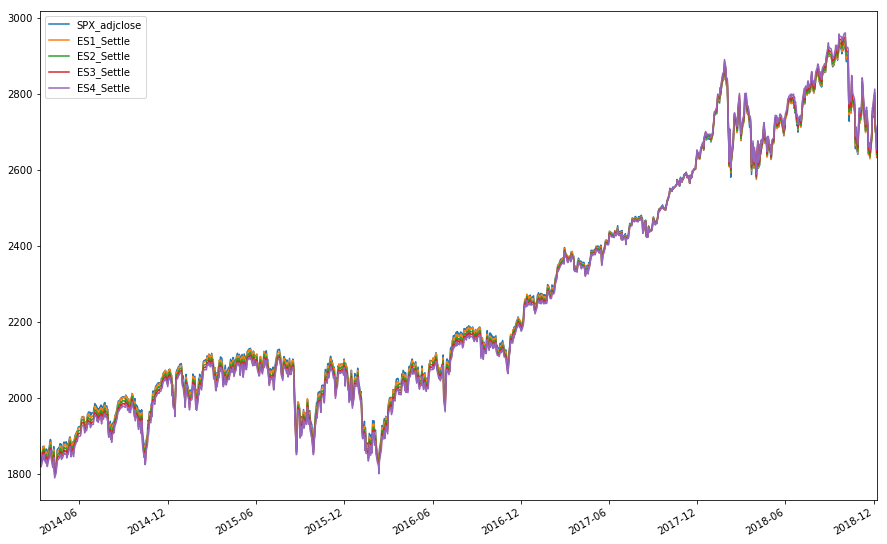

In [96]:
df = pd.concat([spx, es1, es2, es3, es4],axis = 1).dropna()
df[['SPX_adjclose', 'ES1_Settle', 'ES2_Settle', 'ES3_Settle', 'ES4_Settle']].plot(figsize = (15,10))